<a href="https://colab.research.google.com/github/BlueLort/Computer-Vision-Course/blob/main/CV_Assign1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Prepared By**
 **Omar Nasr 4730**

**Ahmed El-Shoubashy          5044**

**This is an assignemnt for Computer Vision Course in Alexandria University.**

**Import Section**





In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import csv

# Part One : Applying Image Processing Filters For Image Cartoonifying


**1.1.1 Noise Reduction Using Median Filter**

We need to reduce the noise in the image before we use a Laplacian edge filter. We will use a
Median filter because it is good at removing noise while keeping edges sharp. Since Laplacian
filters use grayscale images, we must convert from OpenCV’s default BGR format to Grayscale.
Then for noise reduction, we apply a Median filter.

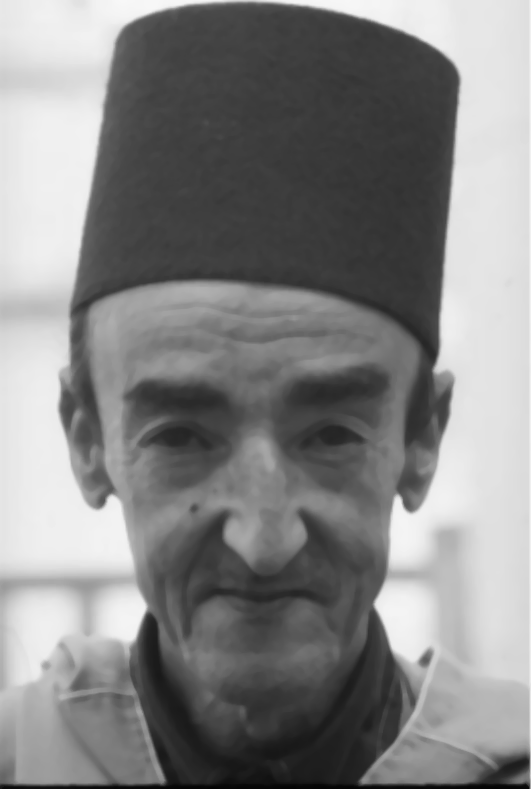

In [ ]:
img = cv2.imread('ex.png',-1) # read image as Gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
medianImg = cv2.medianBlur(gray, ksize= 7) # use median filter
cv2_imshow(medianImg)

**1.1.2 Edge Detection Using Laplacian Filter**

After noise reduction, a Laplacian filter is used for edge detection. The Laplacian filter produces
edges with varying brightness, so to make the edges look more like a sketch we apply a binary
threshold to make the edges either white or black.


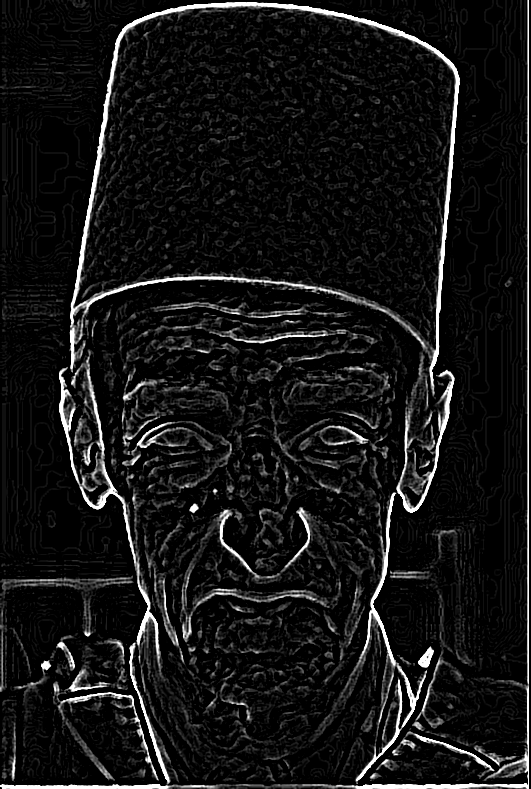

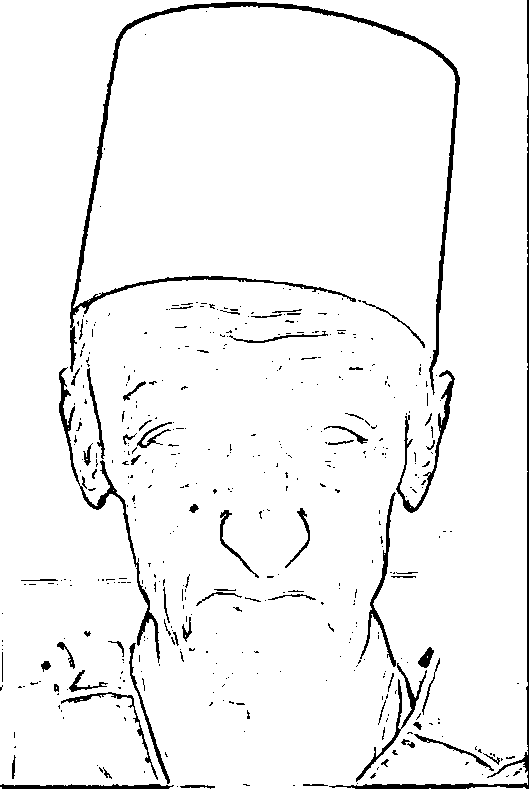

In [ ]:
laplacianImg = cv2.Laplacian( medianImg ,ddepth = -1, ksize = 5)
_,maskImg = cv2.threshold(laplacianImg, 127, 255, cv2.THRESH_BINARY_INV)
cv2_imshow(laplacianImg)
cv2_imshow(maskImg)

**1.2 Generating a color painting and a cartoon**

A strong bilateral filter smoothes flat regions while keeping edges sharp, and is therefore great as
an automatic cartoonifier or painting filter, except that it is extremely slow (that is, measured
in seconds or even minutes rather than milliseconds!). We will therefore use some tricks to
obtain a nice cartoonifier that still runs at an acceptable speed. The most important trick we
can use is to perform bilateral filtering at a lower resolution. It will have a similar effect as at
full resolution.



Rather than applying a large bilateral filter, we will apply many small bilateral filters to
produce a strong cartoon effect in less time. We will truncate the filter so that instead of
performing a whole filter (for example, a filter size of 21 x 21), it just uses the minimum filter
size needed for a convincing result (for example, with a filter size of just 9 x 9).
We have four parameters that control the bilateral filter: color strength, positional strength,
size, and repetition count.

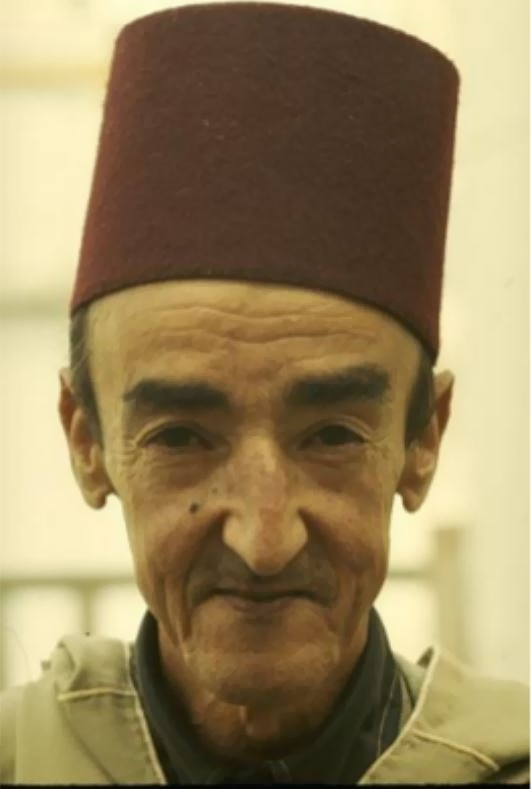

In [ ]:
bilateralImg = img
for rep in range(5):
  bilateralImg = cv2.bilateralFilter(bilateralImg, d = 5, sigmaColor = 5, sigmaSpace = 7)
cv2_imshow(bilateralImg)

**Final Cartoony Image out**

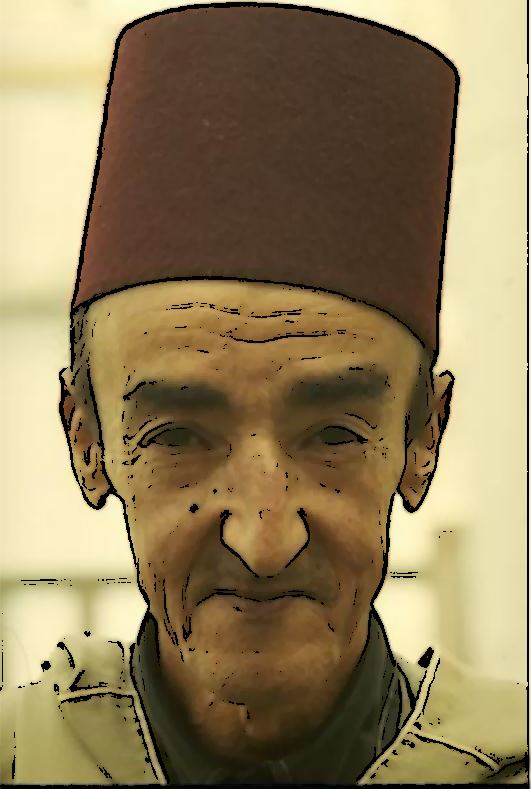

In [ ]:
maskImg = cv2.cvtColor(maskImg, cv2.COLOR_GRAY2RGB)
cartoonImg = cv2.bitwise_and(bilateralImg, maskImg)
cv2_imshow(cartoonImg)

# Part Two: Coins Detection Using Hough Transform

**Smoothing the image using median filter**

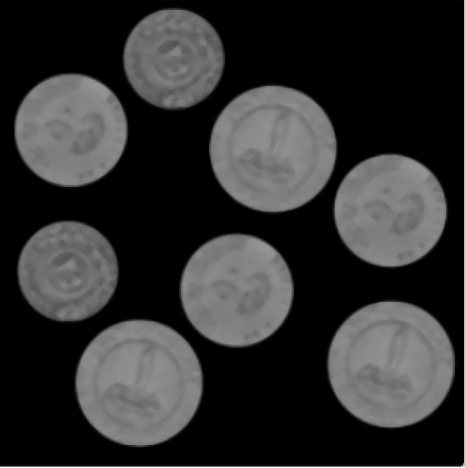

In [ ]:
img = cv2.imread('coins.png',-1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
medianImg = cv2.medianBlur(gray, ksize= 7) # use median filter
cv2_imshow(medianImg)

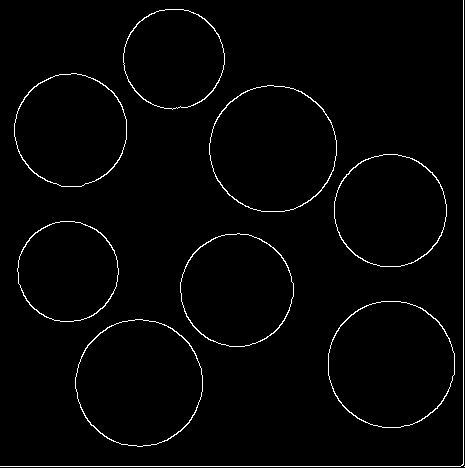

In [ ]:
edges = cv2.Canny(medianImg,160,200)
cv2_imshow(edges)

**Precompute Sine Cosine values for optimization**

In [ ]:
def precomputeSineCosine(phiRange):
  sine = dict()
  cosine = dict()
  for phi in phiRange:
    sine[phi] = np.sin(phi)
    cosine[phi] = np.cos(phi)
  return sine,cosine

**Hough Circle Transform**

The algorithm of hough transform we need to compute

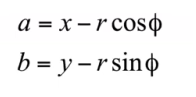

For a,b center of the circle we need to accumlate votes by searching over the image for the edge points with preset radius & precomputed sin(phi) & cos(phi)

after collecting the sum array we need to remove some of the inaccuracies by eliminating some votes that does not meet certain vote limit.


In [ ]:
def houghTransformCircle(radius , threshhold, minimumVotes, sinDict, cosDict , phiRange):
  circles = []
  H = np.zeros(edges.shape)
  rows = edges.shape[0]
  columns = edges.shape[1]
  for y in range(rows):
    for x in range(columns):
      if edges[y][x] == 255:
        #edge point then we need to find the a,b satisfying these x,y locations
        for phi in phiRange:
          a = int(np.round(x - radius * sinDict[phi]))
          b = int(np.round(y - radius * cosDict[phi]))
          #check if a,b are coords in the image
          if a >= 0 and b >= 0 and b <rows and a<columns:
             H[b,a] = H[b,a] + 1
  maxAcc = np.max(H)
  H[H < maxAcc - threshhold] = 0
  for b in range(rows):
    for a in range(columns):
     if H[b,a] > (minimumVotes):
        circles.append((a,b))
  return circles

**Elimination of Duplicate circles**

after running the hough transform algorithm some points are really close and have relatively high votes so we keep 1 circle in certain epsilon distance so that we won't have duplicate circles in that position.

In [ ]:
def eliminateDuplicates(circles, epsilon = 128):
  i = 0
  while i < len(circles):
    x1,y1 = circles[i]
    j = i + 1
    while j <len(circles):
      x2,y2 = circles[j]
      dx = x2-x1
      dy = y2-y1
      if dx*dx + dy*dy < epsilon:
        circles.pop(j)
        j = j - 1
      j = j + 1
    i = i + 1
  return circles

**Running & Output**

running the functions all together with certain parameters to view the final output.

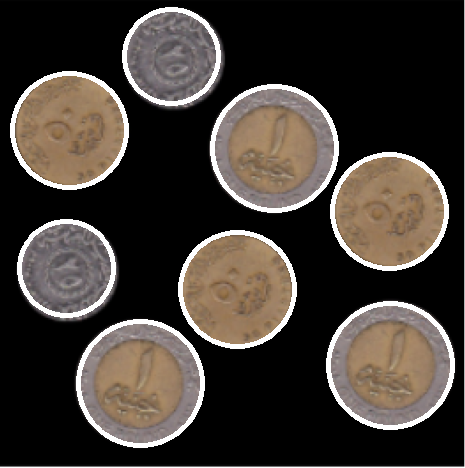

In [ ]:
CONSTANT_DATA = [(62,7,70,(0,0,255)),(57,15,30,(0,255,0)),(47,15,20,(255,0,0))]
THICKNESS = 4
phiRange = np.linspace(0, 360, 360)
sinDict,cosDict = precomputeSineCosine(phiRange)
returnedImg = cv2.imread('coins.png',-1)
for i in range(3):
  circles = houghTransformCircle(CONSTANT_DATA[i][0] ,CONSTANT_DATA[i][1], CONSTANT_DATA[i][2], sinDict, cosDict , phiRange)
  #print(len(circles))
  circles = eliminateDuplicates(circles)
  #print(len(circles))
  for circle in circles:
   cv2.circle(returnedImg , circle, CONSTANT_DATA[i][0], CONSTANT_DATA[i][3], THICKNESS)
cv2_imshow(returnedImg)